In [216]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import shutil

from copy import deepcopy
import argparse

sys.path.append(os.path.abspath('../'))
from utils import _convert_oak_path

from MultiStatePerturbSeqDataset import *
from DE_analysis_utils import *

import yaml

# Load color palettes from yaml file
with open('../../metadata/figure_palettes.yaml', 'r') as f:
    palettes = yaml.safe_load(f)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configure matplotlib for Illustrator-compatible PDFs
mpl.rcParams['pdf.fonttype'] = 42  # Embed fonts as TrueType
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

# Increase all font sizes
plt.rcParams['font.size'] = 16  # Base font size
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15


sys.path.append(os.path.abspath('../'))
from utils import _convert_oak_path
from merge_DE_results import parse_DE_results_2_adata


In [ ]:
# Load configuration from YAML file
with open('DE_config_full.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']

# Load pseudobulk data
pbulk_adata = anndata.experimental.read_lazy(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad')
pbulk_adata = pbulk_adata[(pbulk_adata.obs['keep_for_DE']) & (pbulk_adata.obs['perturbed_gene_name'] == 'NTC')].copy()
pbulk_adata = pbulk_adata.to_memory()

In [54]:
# Load configuration from YAML file
with open('DE_config_full.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']
run_name = config.get('run_name', 'default')
datadir = f'{datadir}/{experiment_name}'
de_results_dir = f'{datadir}/DE_results_{run_name}/'

In [53]:
# Keep genes to test
de_test_genes = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad').var_names.copy()
pbulk_adata = pbulk_adata[:, de_test_genes].copy()

In [189]:
def _run_DE_calibration(pbulk_adata, cond, run_de_params, design_formula, min_counts_per_gene = 10):    
    pdata = pbulk_adata[pbulk_adata.obs['culture_condition'] == cond].copy()
    # Run DE analysis
    ms_perturb_data = MultistatePerturbSeqDataset(
        pdata,
        sample_cols = ['cell_sample_id'],
        perturbation_type = 'CRISPRi',
        target_col = 'perturbed_gene_id',
        sgrna_col = 'guide_id',
        state_col = 'culture_condition',
        control_level = 'NTC'
        )
    model, results = ms_perturb_data.run_target_DE(
        design_formula = design_formula,
        test_state = [cond], test_targets=['ENSG0000X'],
        min_counts_per_gene = min_counts_per_gene,
        return_model = True,
        n_cpus=5
        )
    results['design'] = design_formula
    results['culture_condition'] = cond
    return(results)
    

# Make 3 different splits using 5 different seeds
split_results = []
split_seeds = [42, 123, 2024, 5467, 3232]

# Keep guides with reasonable n of cells
n_cells_ntc_guide = pbulk_adata.obs.groupby('guide_id')['n_cells'].sum()
lower_05, upper_95 = n_cells_ntc_guide.quantile([0.05, 0.95])
all_ntc_guides = n_cells_ntc_guide[(n_cells_ntc_guide >= lower_05) & (n_cells_ntc_guide <= upper_95)].index.tolist()
n_sample = 2 # Same number as targeting guides per gene

for split_idx, seed in enumerate(split_seeds):
    np.random.seed(seed)
    fake_target_ntc_guides = np.random.choice(all_ntc_guides, size=n_sample, replace=False)
    # Add a split-specific column for identifier and label
    pbulk_adata.obs[f'perturbed_gene_id_split{split_idx+1}'] = np.where(
        pbulk_adata.obs['guide_id'].isin(fake_target_ntc_guides), 'ENSG0000X', 'NTC')
    pbulk_adata.obs[f'perturbed_gene_name_split{split_idx+1}'] = np.where(
        pbulk_adata.obs['guide_id'].isin(fake_target_ntc_guides), 'TARGET', 'NTC')
   
    split_results.append(pbulk_adata.obs[f'perturbed_gene_name_split{split_idx+1}'].value_counts())

In [190]:
for split_idx, seed in enumerate(split_seeds):
    print(pbulk_adata.obs.groupby(f'perturbed_gene_id_split{split_idx+1}')['n_cells'].mean())

perturbed_gene_id_split1
ENSG0000X    57.000000
NTC          91.099105
Name: n_cells, dtype: float64
perturbed_gene_id_split2
ENSG0000X    59.888889
NTC          91.084103
Name: n_cells, dtype: float64
perturbed_gene_id_split3
ENSG0000X    55.913043
NTC          91.108171
Name: n_cells, dtype: float64
perturbed_gene_id_split4
ENSG0000X    57.095238
NTC          91.098911
Name: n_cells, dtype: float64
perturbed_gene_id_split5
ENSG0000X    45.000000
NTC          91.119129
Name: n_cells, dtype: float64


In [191]:
# Display value counts for each split
all_res_df = pd.DataFrame()
for idx, res in enumerate(split_results):
    for c in ['Rest', 'Stim8hr', 'Stim48hr']:
        pbulk_adata.obs['perturbed_gene_id'] = pbulk_adata.obs[f'perturbed_gene_id_split{idx+1}'].copy()
        pbulk_adata.obs['perturbed_gene_name'] = pbulk_adata.obs[f'perturbed_gene_name_split{idx+1}'].copy()
        res_df = _run_DE_calibration(
            pbulk_adata, cond=c,
            run_de_params = config.get('run_DE_params', {}),
            design_formula = config.get('run_DE_params', {}).get('design_formula', '~ log10_n_cells + target'),
            )
        res_df['seed'] = split_seeds[idx]
        all_res_df = pd.concat([all_res_df, res_df])

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    6.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.1s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                  baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003   0.006410       -0.085137  10.740781 -0.007927  0.993676   
ENSG00000000419  91.736413        0.139289   0.072091  1.932122  0.053344   
ENSG00000000457  23.412127        0.034071   0.119451  0.285227  0.775470   
ENSG00000000460  53.466801       -0.074396   0.127104 -0.585321  0.558332   
ENSG00000000938   0.060005        0.165620   1.746270  0.094842  0.924440   
...                    ...             ...        ...       ...       ...   
ENSG00000288722   0.793254       -0.137817   0.723993 -0.190357  0.849030   
ENSG00000290292  14.826147        0.001972   0.151972  0.012977  0.989646   
ENSG00000290797   3.473262       -0.739783   0.505269 -1.464136  0.143157   
ENSG00000291096   0.205462       -0.459624   1.160548 -0.396040  0.692075   
ENSG00000291237  46.269852       -0.169528   0.102767 -1.649632  0.09901

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003    0.017771       -0.171954  5.134509 -0.033490  0.973284   
ENSG00000000419  164.468532       -0.038855  0.054063 -0.718700  0.472326   
ENSG00000000457   23.539652        0.168415  0.121775  1.382999  0.166665   
ENSG00000000460   48.869250       -0.035087  0.120926 -0.290156  0.771697   
ENSG00000000938    0.117281       -0.563382  1.742280 -0.323359  0.746423   
...                     ...             ...       ...       ...       ...   
ENSG00000288722    1.344941        0.135701  0.566784  0.239423  0.810777   
ENSG00000290292   13.705209       -0.307145  0.184960 -1.660601  0.096794   
ENSG00000290797    0.279792       -0.420436  1.194091 -0.352097  0.724765   
ENSG00000291096    0.169726        1.129548  0.804852  1.403423  0.160491   
ENSG00000291237   68.360617       -0.068813  0.104036 -0.661432  0.50833

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003    0.006117        0.078775  12.510840  0.006297  0.994976   
ENSG00000000419  185.447570       -0.004097   0.057957 -0.070684  0.943649   
ENSG00000000457   22.323444       -0.063134   0.129857 -0.486183  0.626837   
ENSG00000000460   72.615830        0.053920   0.082071  0.656992  0.511186   
ENSG00000000938    0.180512       -0.341934   1.291555 -0.264746  0.791205   
...                     ...             ...        ...       ...       ...   
ENSG00000288722    0.720144       -0.872910   0.932182 -0.936416  0.349059   
ENSG00000290292   15.669796       -0.002787   0.159158 -0.017508  0.986032   
ENSG00000290797    0.894325        0.393563   0.663039  0.593574  0.552797   
ENSG00000291096    0.156385       -0.207000   1.274451 -0.162423  0.870973   
ENSG00000291237   59.989615       -0.059317   0.084585 -0.701

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                  baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003   0.006410       -0.010719  12.392559 -0.000865  0.999310   
ENSG00000000419  91.736413       -0.192952   0.082699 -2.333192  0.019638   
ENSG00000000457  23.412127        0.248138   0.122184  2.030856  0.042270   
ENSG00000000460  53.466801       -0.083408   0.134624 -0.619562  0.535546   
ENSG00000000938   0.060005       -0.273931   2.109605 -0.129850  0.896685   
...                    ...             ...        ...       ...       ...   
ENSG00000288722   0.793254       -0.102844   0.677556 -0.151787  0.879355   
ENSG00000290292  14.826147       -0.038121   0.166753 -0.228610  0.819172   
ENSG00000290797   3.473262        0.643641   0.416188  1.546515  0.121980   
ENSG00000291096   0.205462        0.414300   1.041571  0.397765  0.690803   
ENSG00000291237  46.269852       -0.074793   0.110039 -0.679695  0.49669

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003    0.017771        0.354774  5.082639  0.069801  0.944352   
ENSG00000000419  164.468532       -0.030531  0.054038 -0.564995  0.572077   
ENSG00000000457   23.539652       -0.251915  0.136968 -1.839222  0.065883   
ENSG00000000460   48.869250        0.100876  0.116969  0.862413  0.388460   
ENSG00000000938    0.117281        0.792918  1.395764  0.568089  0.569975   
...                     ...             ...       ...       ...       ...   
ENSG00000288722    1.344941       -0.267234  0.574558 -0.465113  0.641850   
ENSG00000290292   13.705209        0.165291  0.164799  1.002985  0.315868   
ENSG00000290797    0.279792       -0.509842  1.220003 -0.417902  0.676019   
ENSG00000291096    0.169726       -0.598628  1.396335 -0.428714  0.668132   
ENSG00000291237   68.360617       -0.127434  0.104021 -1.225082  0.22054

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003    0.006117       -0.108003  13.508519 -0.007995  0.993621   
ENSG00000000419  185.447570        0.044776   0.056122  0.797841  0.424963   
ENSG00000000457   22.323444       -0.122309   0.132413 -0.923694  0.355646   
ENSG00000000460   72.615830       -0.080659   0.083090 -0.970744  0.331676   
ENSG00000000938    0.180512        0.246706   1.090928  0.226143  0.821090   
...                     ...             ...        ...       ...       ...   
ENSG00000288722    0.720144       -0.070347   0.682399 -0.103088  0.917894   
ENSG00000290292   15.669796       -0.292584   0.166591 -1.756307  0.079036   
ENSG00000290797    0.894325        0.226158   0.653053  0.346308  0.729111   
ENSG00000291096    0.156385        0.414880   1.062007  0.390656  0.696051   
ENSG00000291237   59.989615       -0.026444   0.082405 -0.320

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                  baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003   0.006410       -0.096282  10.739942 -0.008965  0.992847   
ENSG00000000419  91.736413        0.002780   0.072262  0.038468  0.969314   
ENSG00000000457  23.412127        0.131263   0.115667  1.134838  0.256443   
ENSG00000000460  53.466801       -0.083276   0.120238 -0.692592  0.488566   
ENSG00000000938   0.060005       -0.284370   1.827376 -0.155616  0.876335   
...                    ...             ...        ...       ...       ...   
ENSG00000288722   0.793254       -0.093550   0.567083 -0.164968  0.868970   
ENSG00000290292  14.826147       -0.160038   0.157077 -1.018849  0.308275   
ENSG00000290797   3.473262       -0.477885   0.453233 -1.054393  0.291703   
ENSG00000291096   0.205462        0.387855   0.845420  0.458772  0.646398   
ENSG00000291237  46.269852       -0.001135   0.097558 -0.011638  0.99071

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003    0.017771       -0.066856  4.451197 -0.015020  0.988016   
ENSG00000000419  164.468532        0.033433  0.049036  0.681808  0.495360   
ENSG00000000457   23.539652       -0.130398  0.125342 -1.040332  0.298186   
ENSG00000000460   48.869250        0.224154  0.103593  2.163784  0.030481   
ENSG00000000938    0.117281       -0.381457  1.509579 -0.252691  0.800507   
...                     ...             ...       ...       ...       ...   
ENSG00000288722    1.344941        0.435141  0.408810  1.064408  0.287144   
ENSG00000290292   13.705209        0.020491  0.157594  0.130024  0.896547   
ENSG00000290797    0.279792       -0.095487  0.955201 -0.099965  0.920372   
ENSG00000291096    0.169726       -0.163500  1.034928 -0.157982  0.874471   
ENSG00000291237   68.360617       -0.148799  0.095127 -1.564210  0.11776

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003    0.006117       -0.110014  12.507525 -0.008796  0.992982   
ENSG00000000419  185.447570        0.056965   0.050675  1.124122  0.260961   
ENSG00000000457   22.323444       -0.047431   0.116078 -0.408618  0.682820   
ENSG00000000460   72.615830       -0.020320   0.073713 -0.275668  0.782803   
ENSG00000000938    0.180512       -0.489631   1.182802 -0.413959  0.678904   
...                     ...             ...        ...       ...       ...   
ENSG00000288722    0.720144       -0.248308   0.616109 -0.403025  0.686930   
ENSG00000290292   15.669796       -0.165625   0.143792 -1.151838  0.249388   
ENSG00000290797    0.894325       -0.405607   0.672310 -0.603303  0.546307   
ENSG00000291096    0.156385       -0.385796   1.135583 -0.339734  0.734057   
ENSG00000291237   59.989615       -0.106473   0.076723 -1.387

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                  baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003   0.006410        0.106731  11.475807  0.009301  0.992579   
ENSG00000000419  91.736413       -0.115414   0.077594 -1.487401  0.136909   
ENSG00000000457  23.412127        0.269302   0.114745  2.346963  0.018927   
ENSG00000000460  53.466801       -0.188714   0.131394 -1.436242  0.150933   
ENSG00000000938   0.060005        0.316203   1.850421  0.170882  0.864317   
...                    ...             ...        ...       ...       ...   
ENSG00000288722   0.793254       -0.696840   0.806094 -0.864465  0.387333   
ENSG00000290292  14.826147        0.287581   0.143068  2.010103  0.044420   
ENSG00000290797   3.473262        0.159109   0.430114  0.369922  0.711440   
ENSG00000291096   0.205462       -0.508229   1.302411 -0.390222  0.696373   
ENSG00000291237  46.269852       -0.003901   0.102859 -0.037923  0.96974

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   12.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003    0.017771       -0.041277  4.754097 -0.008682  0.993072   
ENSG00000000419  164.468532        0.048754  0.053273  0.915171  0.360102   
ENSG00000000457   23.539652        0.032924  0.130335  0.252608  0.800571   
ENSG00000000460   48.869250       -0.149536  0.119747 -1.248768  0.211750   
ENSG00000000938    0.117281       -0.380852  1.621457 -0.234883  0.814300   
...                     ...             ...       ...       ...       ...   
ENSG00000288722    1.344941        0.469877  0.469872  1.000011  0.317305   
ENSG00000290292   13.705209       -0.370975  0.195026 -1.902186  0.057147   
ENSG00000290797    0.279792       -0.026778  1.036760 -0.025829  0.979394   
ENSG00000291096    0.169726       -0.119099  1.141210 -0.104362  0.916882   
ENSG00000291237   68.360617        0.154208  0.097070  1.588624  0.11214

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   4 out of   6 | elapsed:    0.0s remaining:    0.0s
[

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003    0.006117       -0.020712  12.507575 -0.001656  0.998679   
ENSG00000000419  185.447570       -0.103932   0.057214 -1.816560  0.069284   
ENSG00000000457   22.323444        0.009391   0.129828  0.072337  0.942334   
ENSG00000000460   72.615830        0.078595   0.080225  0.979687  0.327241   
ENSG00000000938    0.180512       -0.572167   1.333776 -0.428983  0.667936   
...                     ...             ...        ...       ...       ...   
ENSG00000288722    0.720144       -0.613073   0.820543 -0.747155  0.454970   
ENSG00000290292   15.669796        0.113064   0.152328  0.742245  0.457939   
ENSG00000290797    0.894325        0.500387   0.604186  0.828199  0.407558   
ENSG00000291096    0.156385       -0.061656   1.153912 -0.053433  0.957387   
ENSG00000291237   59.989615       -0.006600   0.083196 -0.079

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 12901 out of 12901 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                  baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003   0.006410       -0.005714  11.482300 -0.000498  0.999603   
ENSG00000000419  91.736413       -0.112222   0.087967 -1.275728  0.202052   
ENSG00000000457  23.412127        0.059024   0.141975  0.415734  0.677605   
ENSG00000000460  53.466801       -0.091591   0.142982 -0.640575  0.521799   
ENSG00000000938   0.060005       -0.089904   1.956223 -0.045958  0.963344   
...                    ...             ...        ...       ...       ...   
ENSG00000288722   0.793254       -1.003385   1.051433 -0.954302  0.339931   
ENSG00000290292  14.826147        0.049864   0.179837  0.277273  0.781571   
ENSG00000290797   3.473262       -0.502376   0.566752 -0.886412  0.375395   
ENSG00000291096   0.205462       -0.342457   1.249685 -0.274034  0.784058   
ENSG00000291237  46.269852        0.015579   0.114941  0.135540  0.89218

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:   11.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 13012 out of 13012 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   9 out of   9 | elapsed:    0.0s finished
Fitting dis

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange     lfcSE      stat    pvalue  \
ENSG00000000003    0.017771        0.000407  4.758609  0.000086  0.999932   
ENSG00000000419  164.468532        0.068043  0.059452  1.144513  0.252411   
ENSG00000000457   23.539652        0.136854  0.141544  0.966865  0.333612   
ENSG00000000460   48.869250       -0.032410  0.131078 -0.247258  0.804709   
ENSG00000000938    0.117281        0.655149  1.390816  0.471054  0.637602   
...                     ...             ...       ...       ...       ...   
ENSG00000288722    1.344941        0.620954  0.483588  1.284057  0.199122   
ENSG00000290292   13.705209        0.071656  0.191166  0.374838  0.707781   
ENSG00000290797    0.279792       -0.376738  1.265286 -0.297749  0.765894   
ENSG00000291096    0.169726       -0.253382  1.252588 -0.202287  0.839693   
ENSG00000291237   68.360617       -0.142193  0.113991 -1.247409  0.21224

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:   12.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 5130 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 13373 out of 13373 | elapsed:    4.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
ENSG00000000003    0.006117        0.011809  13.513155  0.000874  0.999303   
ENSG00000000419  185.447570       -0.113983   0.063971 -1.781795  0.074783   
ENSG00000000457   22.323444        0.012768   0.138179  0.092405  0.926376   
ENSG00000000460   72.615830        0.045266   0.088617  0.510806  0.609487   
ENSG00000000938    0.180512       -0.502166   1.411172 -0.355850  0.721953   
...                     ...             ...        ...       ...       ...   
ENSG00000288722    0.720144        0.216742   0.648958  0.333984  0.738391   
ENSG00000290292   15.669796        0.071975   0.166652  0.431885  0.665825   
ENSG00000290797    0.894325       -0.646384   0.969827 -0.666494  0.505095   
ENSG00000291096    0.156385       -0.420510   1.396437 -0.301131  0.763315   
ENSG00000291237   59.989615       -0.003136   0.091246 -0.034

... done in 1.07 seconds.



In [193]:
all_res_df.to_csv(f'{de_results_dir}/DE_calibration_results.csv')

In [194]:
(all_res_df['adj_p_value'] < 0.1).value_counts()

adj_p_value
False    196413
True         17
Name: count, dtype: int64

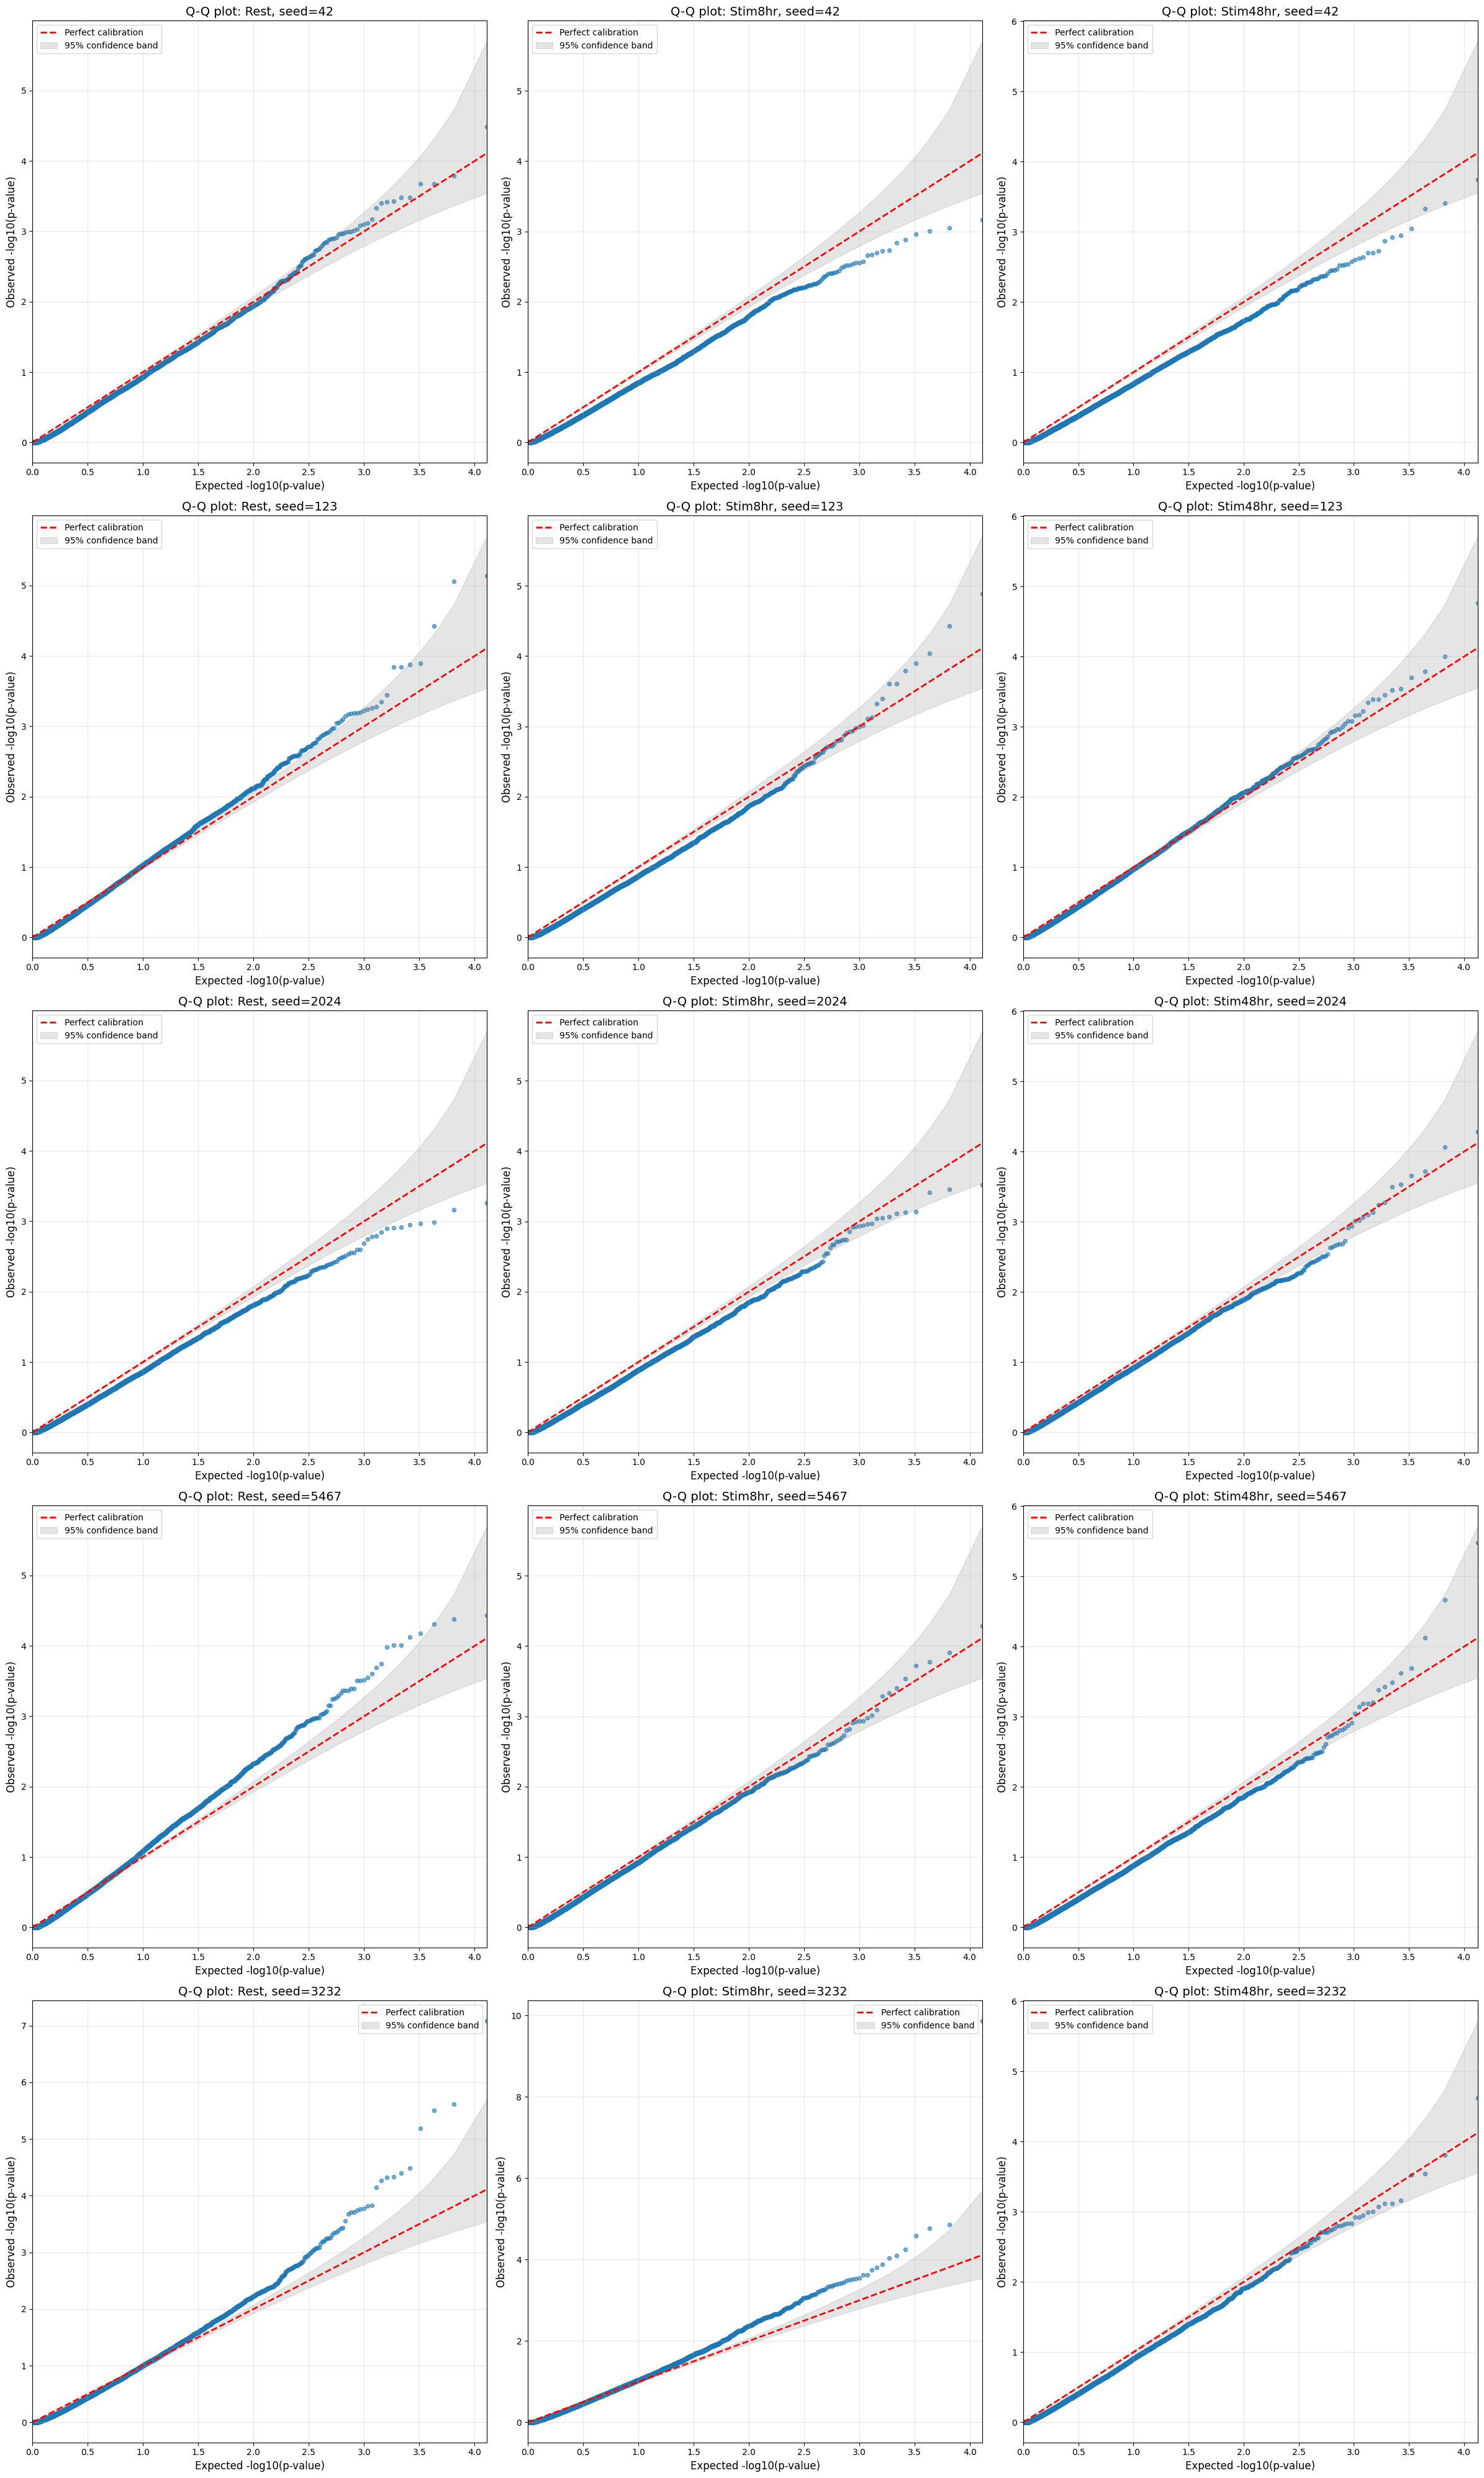

In [195]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pvalue_qq(pvalues, title="P-value QQ Plot", ax=None):
    """
    Create a QQ plot to assess p-value calibration using -log10 scale.

    Parameters:
    -----------
    pvalues : array-like
        Vector of p-values to assess
    title : str
        Title for the plot
    ax : matplotlib.axes.Axes or None
        Axes to plot on. If None, creates a new figure and axes.
    """
    # Remove NaN values and sort
    pvalues = np.array(pvalues)
    pvalues = pvalues[~np.isnan(pvalues)]
    pvalues_sorted = np.sort(pvalues)

    # Calculate expected p-values under uniform distribution
    n = len(pvalues_sorted)
    expected = np.arange(1, n + 1) / (n + 1)

    # Transform to -log10 scale
    observed_log = -np.log10(pvalues_sorted)
    expected_log = -np.log10(expected)

    # Prepare axes
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    # else: use provided ax

    # Create the plot
    ax.scatter(expected_log, observed_log, alpha=0.6, s=20)

    # Add diagonal line (y=x) representing perfect calibration
    max_expected = expected_log.max()
    ax.plot([0, max_expected], [0, max_expected], 'r--', linewidth=2, label='Perfect calibration')
    ax.set_xlim(0, max_expected)
    # Add confidence bands (optional)
    from scipy.stats import beta
    lower = beta.ppf(0.025, np.arange(1, n + 1), n - np.arange(1, n + 1) + 1)
    upper = beta.ppf(0.975, np.arange(1, n + 1), n - np.arange(1, n + 1) + 1)
    lower_log = -np.log10(lower)
    upper_log = -np.log10(upper)
    ax.fill_between(expected_log, lower_log, upper_log, alpha=0.2, color='gray',
                    label='95% confidence band')

    ax.set_xlabel('Expected -log10(p-value)', fontsize=12)
    ax.set_ylabel('Observed -log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    if ax is None:
        return plt
    else:
        return ax


# Plot Q-Q plot of p-values in one figure, separate axes for each condition and seed
n_seeds = len(split_results)
n_conds = 3  # 'Rest', 'Stim8hr', 'Stim48hr'
fig, axes = plt.subplots(n_seeds, n_conds, figsize=(8*n_conds, 8*n_seeds), squeeze=False)

for idx, res in enumerate(split_results):
    for jdx, c in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
        results = all_res_df[(all_res_df['culture_condition'] == c) & (all_res_df['seed'] == split_seeds[idx])]
        qq_title = f"Q-Q plot: {c}, seed={split_seeds[idx]}"
        plot_pvalue_qq(results.p_value.dropna(), title=qq_title, ax=axes[idx, jdx])

plt.tight_layout()
plt.show()

In [ ]:
adata_de_targeting = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

In [202]:
np.random.seed(42)
all_targets = adata_de_targeting.obs['target_contrast_gene_name'].unique()
# Sample 100 targets at random
sampled_targets = np.random.choice(all_targets, size=30, replace=False)
de_results_df = get_DE_results_long(adata_de_targeting, targets=sampled_targets, signif_estimate='adj_p_value', effect_estimates=['p_value'])

<Axes: title={'center': 'Q-Q plot of p-values by test'}, xlabel='Expected -log10(p-value)', ylabel='Observed -log10(p-value)'>

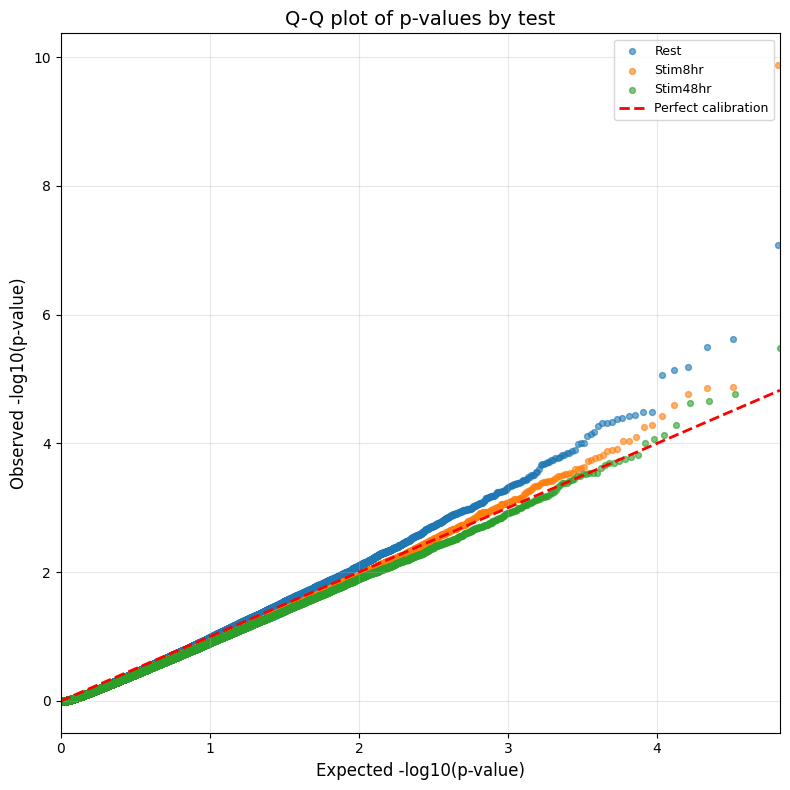

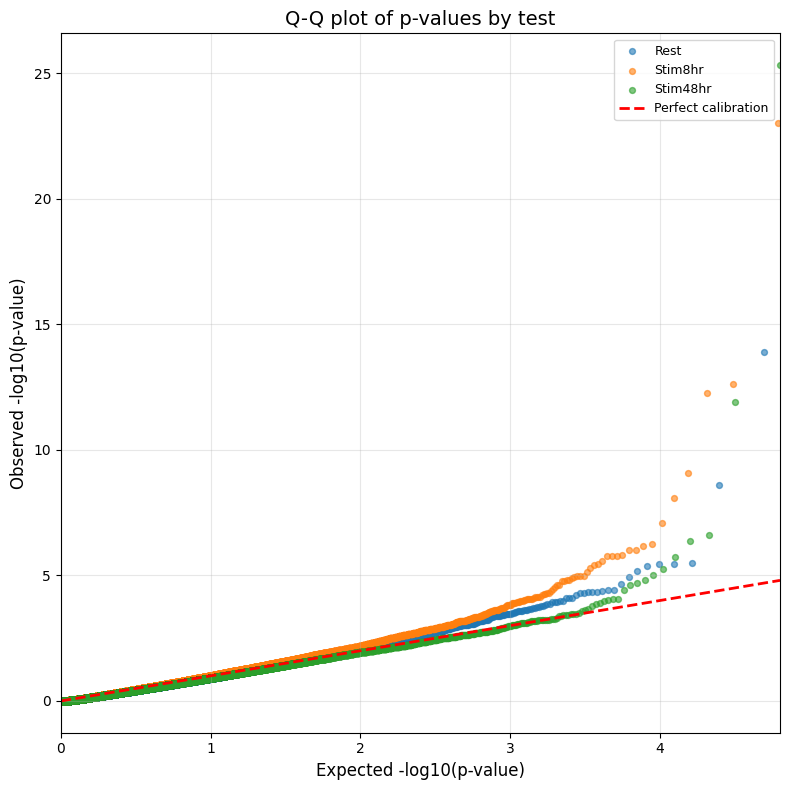

In [ ]:
from scipy.stats import beta

def plot_pvalue_qq_df(df, ax=None, title='Q-Q plot of p-values by test'):
    """
    Plot Q-Q plot for p-values grouped by 'test' column. Each curve is a test.
    Args:
        df: DataFrame with columns ['pvalue', 'test'].
        ax: matplotlib axis object (optional).
        title: Plot title.
    Returns:
        matplotlib axis object or plt
    """
    import matplotlib.pyplot as plt
    import numpy as np

    tests = df['test'].unique()
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    max_x = 0
    for idx, test in enumerate(tests):
        test_pvalues = np.array(df.loc[df['test'] == test, 'p_value'])
        test_pvalues = test_pvalues[~np.isnan(test_pvalues)]
        test_pvalues_sorted = np.sort(test_pvalues)
        n = len(test_pvalues_sorted)
        if n == 0:
            continue

        expected = np.arange(1, n + 1) / (n + 1)
        observed_log = -np.log10(test_pvalues_sorted)
        observed_log = np.where(observed_log > 30, 30, observed_log)
        expected_log = -np.log10(expected)
        # Track the all-dataset max for diagonal
        max_x = max(max_x, expected_log.max())

        ax.scatter(expected_log, observed_log, 
                   alpha=0.6, s=18, 
                   label=str(test) if len(tests)<16 else None
                   )

    # Add diagonal line (y = x)
    ax.plot([0, max_x], [0, max_x], 'r--', linewidth=2, label='Perfect calibration')
    ax.set_xlim(0, max_x)
    ax.set_xlabel('Expected -log10(p-value)', fontsize=12)
    ax.set_ylabel('Observed -log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    if len(tests) < 16:
        ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return ax

# all_res_df['test'] = all_res_df['culture_condition'].astype(str)
# de_results_df['test'] = de_results_df['culture_condition'].copy()
# plot_pvalue_qq_df(all_res_df[['test', 'p_value']])
# plot_pvalue_qq_df(de_results_df[['test', 'p_value']])

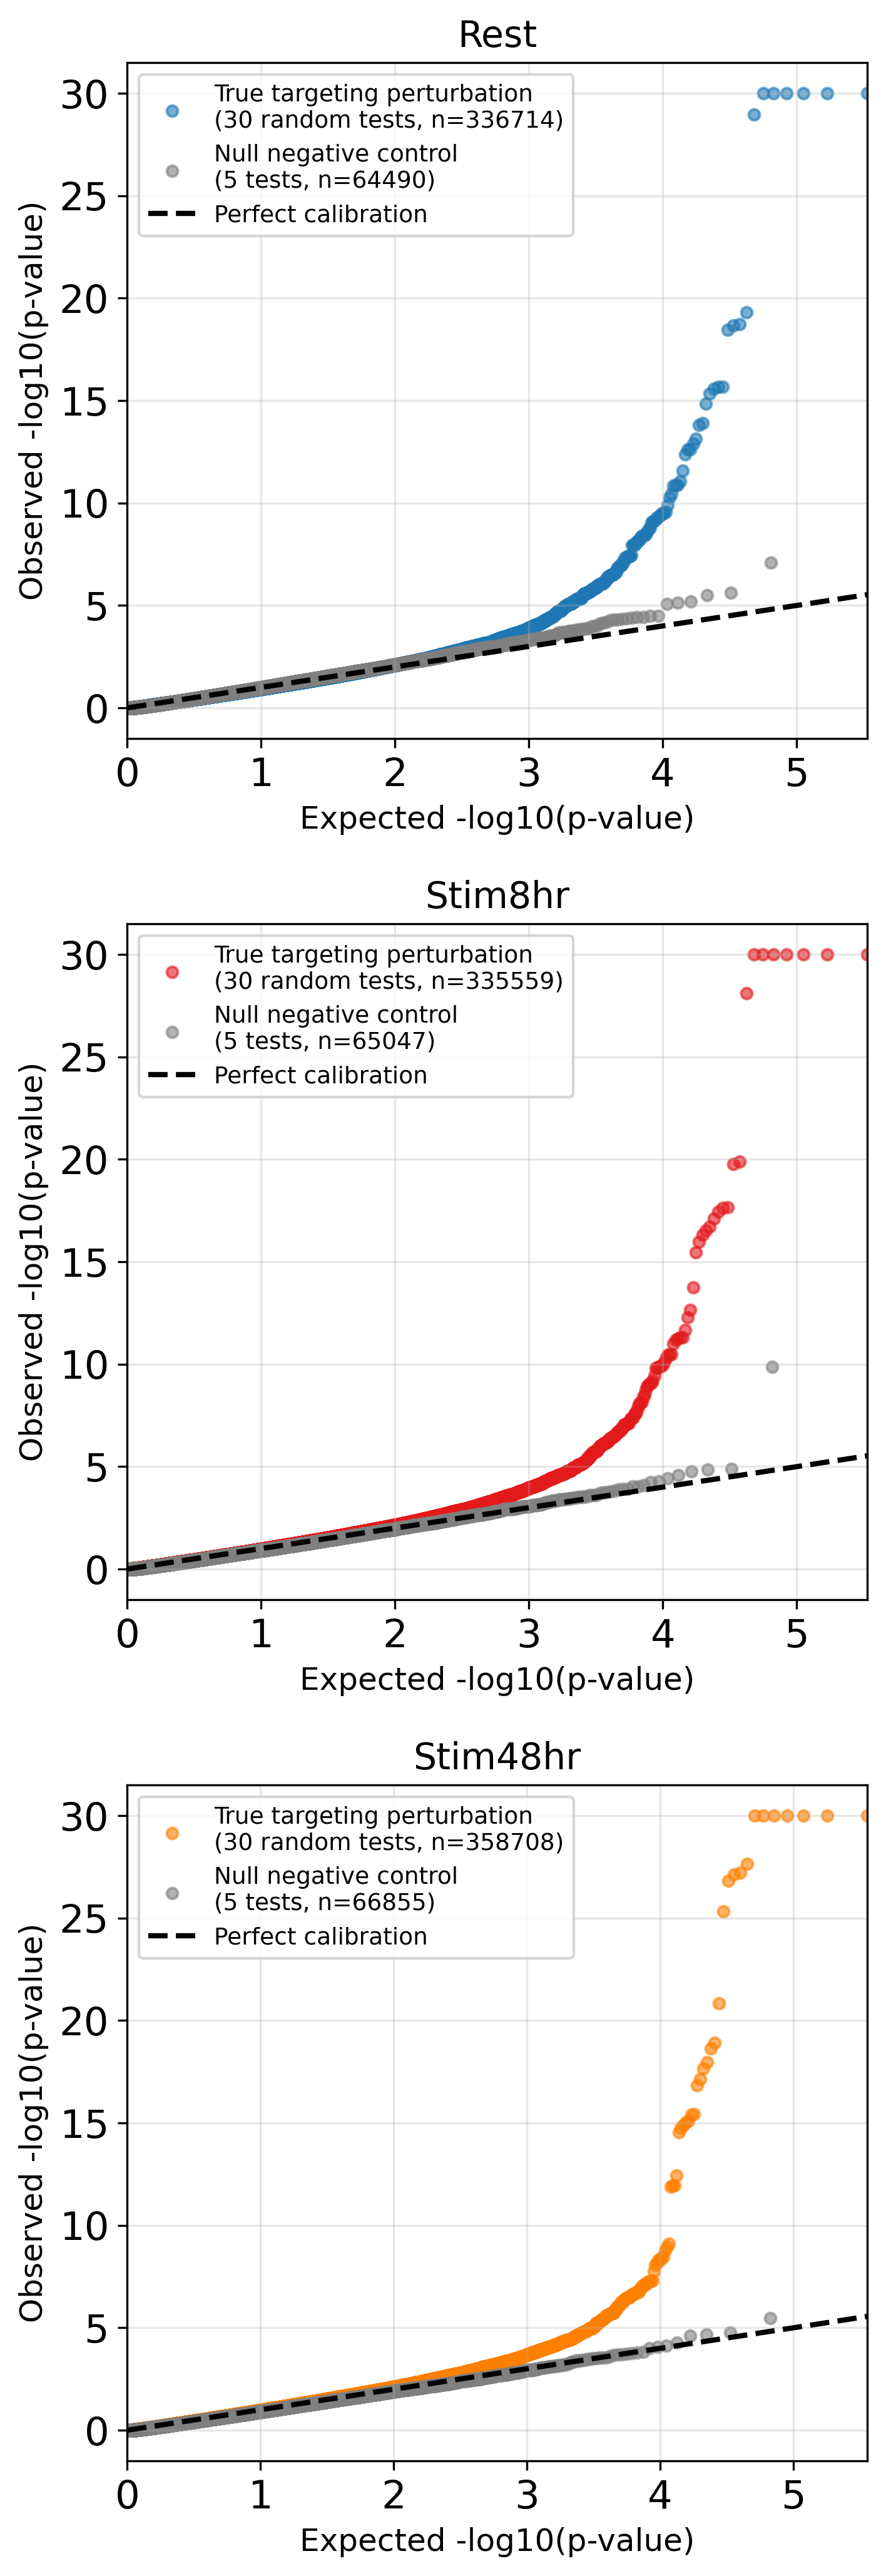

In [217]:
from scipy.stats import beta

import matplotlib.pyplot as plt
import numpy as np

def plot_pvalue_qq_df(df, ax=None, title='Q-Q plot of p-values by test', color_dict=None):
    """
    Plot Q-Q plot for p-values grouped by 'test' column. Each curve is a test.
    Args:
        df: DataFrame with columns ['p_value', 'test'].
        ax: matplotlib axis object (optional).
        title: Plot title.
        color_dict: Optional dict to map 'test' name to color.
    Returns:
        matplotlib axis object or plt
    """
    tests = df['test'].unique()
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    max_x = 0
    for idx, test in enumerate(tests):
        test_pvalues = np.array(df.loc[df['test'] == test, 'p_value'])
        test_pvalues = test_pvalues[~np.isnan(test_pvalues)]
        test_pvalues_sorted = np.sort(test_pvalues)
        n = len(test_pvalues_sorted)
        if n == 0:
            continue

        expected = np.arange(1, n + 1) / (n + 1)
        observed_log = -np.log10(test_pvalues_sorted)
        observed_log = np.where(observed_log > 30, 30, observed_log)
        expected_log = -np.log10(expected)
        # Track the all-dataset max for diagonal
        max_x = max(max_x, expected_log.max())

        color = None
        if color_dict is not None and test in color_dict:
            color = color_dict[test]

        ax.scatter(expected_log, observed_log,
                   alpha=0.6, s=18,
                   label=str(test) if len(tests)<16 else None,
                   color=color
                   )

    # Add diagonal line (y = x)
    ax.plot([0, max_x], [0, max_x], '--', linewidth=2, label='Perfect calibration', color='black')
    ax.set_xlim(0, max_x)
    ax.set_xlabel('Expected -log10(p-value)', fontsize=12)
    ax.set_ylabel('Observed -log10(p-value)', fontsize=12)
    ax.set_title(title, fontsize=14)
    if len(tests) < 16:
        ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return ax

# Create a color mapping for the two classes for each condition
# e.g. { "True targeting perturbation ...": palettes['culture_condition'][c],  "Negative control ...": 'gray' }
colors = {}
for c in ['Rest', 'Stim8hr', 'Stim48hr']:
    colors[c] = {
        f'True targeting perturbation\n(30 random tests, n={{n}})': palettes['culture_condition'][c],
        f'Null negative control\n(5 tests, n={{n}})': 'gray'
    }

fig, axes = plt.subplots(3, 1, figsize=(5, 14), sharey=True)
for i, c in enumerate(['Rest', 'Stim8hr', 'Stim48hr']):
    res_df = all_res_df[all_res_df['culture_condition'] == c].dropna().copy()
    res_df['test'] = f'Null negative control\n(5 tests, n={res_df.shape[0]})'
    true_res_df = de_results_df[de_results_df['culture_condition'] == c].dropna().copy()
    true_res_df['test'] = f'True targeting perturbation\n(30 random tests, n={true_res_df.shape[0]})'
    plot_df = pd.concat([true_res_df, res_df])[['test', 'p_value']].copy()
    # Make color mapping based on actual n
    cond_colors = {
        f'True targeting perturbation\n(30 random tests, n={true_res_df.shape[0]})': palettes['culture_condition'][c],
        f'Null negative control\n(5 tests, n={res_df.shape[0]})': 'gray'
    }
    plot_pvalue_qq_df(plot_df, ax=axes[i], title=c, color_dict=cond_colors)
plt.tight_layout()
plt.savefig('./results/calibration_qqplots.pdf')
plt.savefig('./results/calibration_qqplots.png')